# Intro to AI 4 - CW3 Artifical Neural Networks (ANN)

### Setup

In [12]:
import torch
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader
import random
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import itertools


# Set up seeds (reproduceability)
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

if (torch.cuda.is_available()):
    print("CUDA available. Using device: ", torch.cuda.get_device_name())
else:
    print("CUDA is not available. Using device: ", torch.device("cpu"))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


CUDA available. Using device:  NVIDIA GeForce RTX 3070


#### Data import

In [13]:
DATA_PATH = r"./interest-rates/index.csv"
df = pd.read_csv(DATA_PATH)

df["date"] = pd.to_datetime(df[["Year", "Month", "Day"]])
df = df.sort_values("date")

print(df.shape)
display(df.head())

(904, 11)


,Year,Month,Day,Federal Funds Target Rate,Federal Funds Upper Target,Federal Funds Lower Target,Effective Federal Funds Rate,Real GDP (Percent Change),Unemployment Rate,Inflation Rate,date
0,1954,7,1,NaN,NaN,NaN,0.80,4.6,5.8,NaN,1954-07-01
1,1954,8,1,NaN,NaN,NaN,1.22,NaN,6.0,NaN,1954-08-01
2,1954,9,1,NaN,NaN,NaN,1.06,NaN,6.1,NaN,1954-09-01
3,1954,10,1,NaN,NaN,NaN,0.85,8.0,5.7,NaN,1954-10-01
4,1954,11,1,NaN,NaN,NaN,0.83,NaN,5.3,NaN,1954-11-01


In [14]:
def prepare_quarterly_data(df_in: pd.DataFrame, add_lags: bool = False, max_lag: int = 2):
    target_col = "Real GDP (Percent Change)"
    base_feature_cols = [
        "Effective Federal Funds Rate",
        "Unemployment Rate",
        "Inflation Rate",
    ]

    # using a copy of the data
    temp = df_in.copy()
    temp = temp.set_index("date").sort_index()

    # FF between GDP and keep only relevant
    temp[target_col] = temp[target_col].ffill()
    cols_to_keep = [target_col] + base_feature_cols
    temp = temp[cols_to_keep]

    # Interpolate features in time, then back-fill any remaining NAs
    temp[base_feature_cols] = temp[base_feature_cols].interpolate(method="time")
    temp[base_feature_cols] = temp[base_feature_cols].bfill()

    df_q = temp.resample("QS", label="left").mean()

    # create feature lags on this quarterly index.
    feature_cols = base_feature_cols.copy()

    if add_lags:
        for col in base_feature_cols:
            for lag in range(1, max_lag + 1):
                lag_name = f"{col}_lag{lag}q"
                df_q[lag_name] = df_q[col].shift(lag)
                feature_cols.append(lag_name)

        df_q = df_q.dropna(subset=feature_cols + [target_col]) # Drop rows with inital NAs from the lags

    return df_q, feature_cols


In [15]:
# quarterly data with lags
pipeline_input_down_lag, feature_cols_down_lag = prepare_quarterly_data(
    df, add_lags=True, max_lag=2
)

print("Downsampled quarterly + feature lags shape:", pipeline_input_down_lag.shape)

display(pipeline_input_down_lag.head())

Downsampled quarterly + feature lags shape: (249, 10)


,Real GDP (Percent Change),Effective Federal Funds Rate,Unemployment Rate,Inflation Rate,Effective Federal Funds Rate_lag1q,Effective Federal Funds Rate_lag2q,Unemployment Rate_lag1q,Unemployment Rate_lag2q,Inflation Rate_lag1q,Inflation Rate_lag2q
date,,,,,,,,,,
1955-01-01,11.9,1.343333,4.733333,3.2,0.986667,1.026667,5.333333,5.966667,3.2,3.2
1955-04-01,6.7,1.500000,4.400000,3.2,1.343333,0.986667,4.733333,5.333333,3.2,3.2
1955-07-01,5.5,1.940000,4.100000,3.2,1.500000,1.343333,4.400000,4.733333,3.2,3.2
1955-10-01,2.4,2.356667,4.233333,3.2,1.940000,1.500000,4.100000,4.400000,3.2,3.2
1956-01-01,-1.5,2.483333,4.033333,3.2,2.356667,1.940000,4.233333,4.100000,3.2,3.2


In [16]:

data = pipeline_input_down_lag.sort_index()
data = data.reset_index(drop=True)

train_ratio = 0.70
val_ratio   = 0.15

N = len(data)

train_end = int(N * train_ratio)
val_end   = int(N * (train_ratio + val_ratio))

#Split!
train_df = data.iloc[:train_end]
val_df   = data.iloc[train_end:val_end]
test_df  = data.iloc[val_end:]

X_train = train_df[feature_cols_down_lag].values.astype(np.float32)
y_train = train_df["Real GDP (Percent Change)"].values.astype(np.float32)

X_val   = val_df[feature_cols_down_lag].values.astype(np.float32)
y_val   = val_df["Real GDP (Percent Change)"].values.astype(np.float32)

X_test  = test_df[feature_cols_down_lag].values.astype(np.float32)
y_test  = test_df["Real GDP (Percent Change)"].values.astype(np.float32)



#### Standardisation

In [17]:
scaler = StandardScaler()
scaler.fit(X_train)

# aplly transformation to all other feature sets
X_train_scaled = scaler.transform(X_train).astype(np.float32)
X_val_scaled   = scaler.transform(X_val).astype(np.float32)
X_test_scaled  = scaler.transform(X_test).astype(np.float32)

# Pytorch dataset class
class ff_dataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)

        # Ensure y is always shape (N, 1)
        if len(y.shape) == 1:              # shape (N,)
            y = y.reshape(-1, 1)           # -> shape (N, 1)

        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


train_dataset = ff_dataset(X_train_scaled, y_train)
val_dataset   = ff_dataset(X_val_scaled, y_val)
test_dataset  = ff_dataset(X_test_scaled, y_test)

### Batches

With another helper function so that I can use it later in hyperparameter tuning

In [18]:
batch_size = 16

def loaders_w_batch_size(batch_size):
    train_dataset = ff_dataset(X_train_scaled, y_train)
    val_dataset   = ff_dataset(X_val_scaled,   y_val)
    test_dataset  = ff_dataset(X_test_scaled, y_test)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)
    test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

train_loader, val_loader, test_loader = loaders_w_batch_size(batch_size)

### Helper functions

I'll use these later for training, evaluating and plotting the model.

In [19]:
def train_one_epoch(model, loader, optimiser, criterion, device):
    model.train()
    running_loss = 0.0
    n_samples = 0

    for X_batch, y_batch in loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimiser.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimiser.step()

        batch_size = X_batch.size(0)
        running_loss += loss.item() * batch_size
        n_samples += batch_size

    return running_loss / n_samples

def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    n_samples = 0

    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            batch_size = X_batch.size(0)
            running_loss += loss.item() * batch_size
            n_samples += batch_size

    return running_loss / n_samples

def plot_loss_curves(train_losses, val_losses, model_name="Model"):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_losses, label="Training Loss (MSE)", linewidth=2)
    plt.plot(epochs, val_losses, label="Validation Loss (MSE)", linewidth=2)

    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel("Loss (MSE)", fontsize=12)
    plt.title(f"{model_name} Loss Curves", fontsize=14)
    plt.grid(True, which="both", linestyle="--", alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()


### Baseline MLP Model

#### Model definition

In [20]:
input_dim = X_train_scaled.shape[1]   # define training features size
output_dim = 1                        # only output we want is GDP

class BaselineMLP(nn.Module):
    def __init__(self, in_features, out_features, activation_name="relu"):
        super().__init__()

        # Choose activation
        if activation_name.lower() == "relu":
            act = nn.ReLU()
        elif activation_name.lower() == "tanh":
            act = nn.Tanh()
        elif activation_name.lower() in ["leaky_relu", "leaky-relu", "lrelu"]:
            act = nn.LeakyReLU()
        else:
            raise ValueError(f"Unknown activation_name: {activation_name}")

        self.net = nn.Sequential(
            nn.Linear(in_features, 16),
            act,
            nn.Linear(16, out_features)
        )

    def forward(self, x):
        return self.net(x)

model = BaselineMLP(input_dim, output_dim).to(device)
print(model)


BaselineMLP(
  (net): Sequential(
    (0): Linear(in_features=9, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=1, bias=True)
  )
)


#### Loss function and optimiser

In [21]:
criterion = nn.MSELoss()
optimiser = optim.Adam(model.parameters(), lr=1e-3)

#### Training and evaluation helper functions

These functions can be used with any of the models and will be reused when running through other non-baseline models too.

#### Training loop

[Baseline] Epoch 001 | Train MSE: 29.375373 | Val MSE: 14.847534
[Baseline] Epoch 002 | Train MSE: 28.915019 | Val MSE: 14.362102
[Baseline] Epoch 003 | Train MSE: 28.497243 | Val MSE: 13.895149
[Baseline] Epoch 004 | Train MSE: 28.087551 | Val MSE: 13.434395
[Baseline] Epoch 005 | Train MSE: 27.679086 | Val MSE: 12.971678
[Baseline] Epoch 006 | Train MSE: 27.270397 | Val MSE: 12.501897
[Baseline] Epoch 007 | Train MSE: 26.860034 | Val MSE: 12.027622
[Baseline] Epoch 008 | Train MSE: 26.446624 | Val MSE: 11.543526
[Baseline] Epoch 009 | Train MSE: 26.025395 | Val MSE: 11.045975
[Baseline] Epoch 010 | Train MSE: 25.595054 | Val MSE: 10.530912
[Baseline] Epoch 011 | Train MSE: 25.153578 | Val MSE: 10.001365
[Baseline] Epoch 012 | Train MSE: 24.699593 | Val MSE: 9.455141
[Baseline] Epoch 013 | Train MSE: 24.228234 | Val MSE: 8.888807
[Baseline] Epoch 014 | Train MSE: 23.737117 | Val MSE: 8.322246
[Baseline] Epoch 015 | Train MSE: 23.236168 | Val MSE: 7.766809
[Baseline] Epoch 016 | Train 

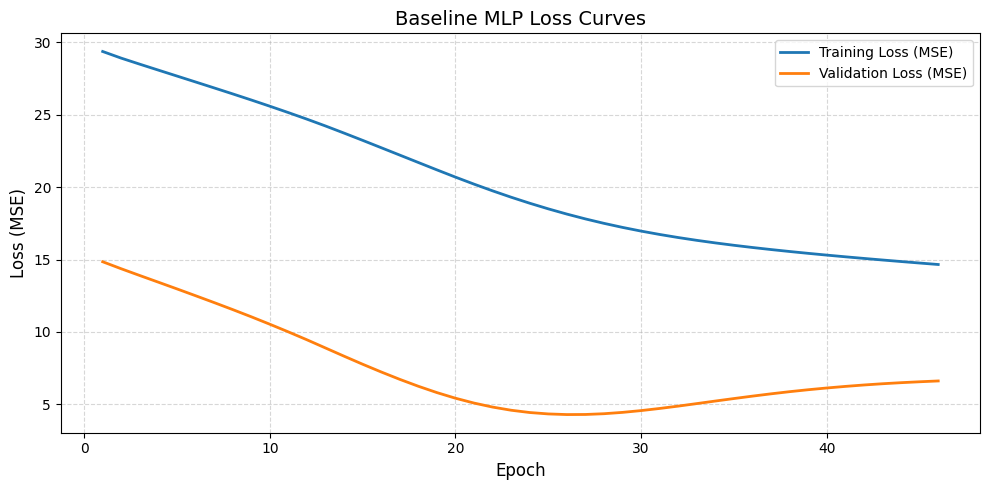

In [22]:
num_epochs = 200 # max number of epochs
patience = 20  # if validation loss doesnt improve after this many epochs, stop.

best_val_loss = float("inf")
best_model_state = None
epochs_no_improve = 0

train_losses = []
val_losses = []

for epoch in range(1, num_epochs + 1):
    train_loss = train_one_epoch(model, train_loader, optimiser, criterion, device)
    val_loss = evaluate(model, val_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"[Baseline] Epoch {epoch:03d} | Train MSE: {train_loss:.6f} | Val MSE: {val_loss:.6f}")

    if val_loss < best_val_loss - 1e-6:  # check for improvement accounting for potential noise
        best_val_loss = val_loss
        best_model_state = model.state_dict()
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    # early stopping
    if epochs_no_improve >= patience:
        print(f"[Baseline] Early stopping triggered after {epoch} epochs.")
        break

# load best model weights
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print("[Baseline] Loaded best model (lowest val MSE).")

test_mse = evaluate(model, test_loader, criterion, device)
print(f"\n[Baseline] Final Test MSE (Baseline MLP): {test_mse:.6f}")

plot_loss_curves(train_losses, val_losses, "Baseline MLP")


The baseline MLP model therefore shows an MSE of around 25, translating to around 4-6 % points. This therefore is not great but works as a good baseline for the model to be developed onto, which is what will be done with the next models. The high MSE value shows that quite a bit of underfitting is taking place in this model. However, before taking this as the baseline's best performance, I will attempt to tune the hyperparameters before moving onto model B

### Baseline MLP tuning

In the code block below I will perform the hyperparameter tuning for the baseline MLP model. This will reuse a lot of the code above (I've decided to keep that above split up for understanding/explanation reasons).


#### Model running function

In [23]:
def run_modelA(learning_rate,
               batch_size,
               weight_decay,
               activation_name,
               num_epochs=200,
               patience=20,
               extra_info=False,
               evaluate_model=False):

    # new model for each run
    model = BaselineMLP(input_dim, output_dim, activation_name=activation_name).to(device)

    # create loaders
    train_loader, val_loader, test_loader = loaders_w_batch_size(batch_size)

    criterion  = nn.MSELoss()
    optimiser  = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    best_val_loss      = float("inf")
    best_train_loss    = float("inf")
    best_model_state = None
    epochs_no_improve  = 0

    if evaluate_model:
        train_losses = []  # only used if evaluate_model=True
        val_losses   = []  # only used if evaluate_model=True

    for epoch in range(1, num_epochs + 1):
        train_loss = train_one_epoch(model, train_loader, optimiser, criterion, device)
        val_loss   = evaluate(model, val_loader, criterion, device)

        if evaluate_model:
            train_losses.append(train_loss)
            val_losses.append(val_loss)

        if extra_info:
            print(
                f"[Baseline tuning] (lr={learning_rate}, bs={batch_size}, "
                f"wd={weight_decay}, act={activation_name}) "
                f"Epoch {epoch:03d} | Train MSE: {train_loss:.6f} | Val MSE: {val_loss:.6f}"
            )

        if val_loss < best_val_loss - 1e-6:  # check for improvement accounting for potential noise
            best_val_loss   = val_loss
            best_model_state = model.state_dict()
            best_train_loss = train_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            break


    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    if evaluate_model:
        test_mse = evaluate(model, test_loader, criterion, device)
        return val_losses, train_losses, test_mse

    return best_val_loss, best_train_loss


#### Hypereparameter grid search

In [24]:
learning_rate_grid = [1e-2, 3e-3, 1e-3]
batch_size_grid    = [16]
weight_decay_grid  = [0.0, 1e-4, 1e-3]
activation_grid    = ["relu", "tanh", "leaky_relu"]

hyperparameter_grid = list(itertools.product(
    learning_rate_grid,
    batch_size_grid,
    weight_decay_grid,
    activation_grid,
))

print(f"[Baseline tuning] Total combinations to test for Model A: {len(hyperparameter_grid)}")

n_runs_per_setting = 3  # evaluate each hyperparameter set 3 times

results = []

for learning_rate, batch_size, weight_decay, activation_name in hyperparameter_grid:
    val_mses   = []
    train_mses = []

    for run_idx in range(n_runs_per_setting):
        # Optional: vary seed for each repeat
        torch.manual_seed(42 + run_idx)
        np.random.seed(42 + run_idx)
        random.seed(42 + run_idx)

        best_val_mse, best_train_mse = run_modelA(
            learning_rate=learning_rate,
            batch_size=batch_size,
            weight_decay=weight_decay,
            activation_name=activation_name,
            num_epochs=200,
            patience=20,
            extra_info=False
        )

        val_mses.append(best_val_mse)
        train_mses.append(best_train_mse)

    mean_val_mse = float(np.mean(val_mses))
    std_val_mse  = float(np.std(val_mses))

    results.append({
        "learning_rate": learning_rate,
        "batch_size": batch_size,
        "weight_decay": weight_decay,
        "activation": activation_name,
        "mean_best_val_mse": mean_val_mse,
        "std_best_val_mse": std_val_mse,
    })

    print(
        f"[Baseline tuning] Done: lr={learning_rate}, bs={batch_size}, "
        f"wd={weight_decay}, act={activation_name} "
        f"-> mean best val MSE = {mean_val_mse:.4f} (std={std_val_mse:.4f})"
    )

results_df_A = pd.DataFrame(results)
display(results_df_A.sort_values("mean_best_val_mse").head(10))


[Baseline tuning] Total combinations to test for Model A: 27
[Baseline tuning] Done: lr=0.01, bs=16, wd=0.0, act=relu -> mean best val MSE = 4.5278 (std=0.1920)
[Baseline tuning] Done: lr=0.01, bs=16, wd=0.0, act=tanh -> mean best val MSE = 4.6121 (std=0.1331)
[Baseline tuning] Done: lr=0.01, bs=16, wd=0.0, act=leaky_relu -> mean best val MSE = 4.4068 (std=0.4609)
[Baseline tuning] Done: lr=0.01, bs=16, wd=0.0001, act=relu -> mean best val MSE = 4.8363 (std=0.3161)
[Baseline tuning] Done: lr=0.01, bs=16, wd=0.0001, act=tanh -> mean best val MSE = 4.6121 (std=0.1331)
[Baseline tuning] Done: lr=0.01, bs=16, wd=0.0001, act=leaky_relu -> mean best val MSE = 4.3945 (std=0.4760)
[Baseline tuning] Done: lr=0.01, bs=16, wd=0.001, act=relu -> mean best val MSE = 4.8561 (std=0.3403)
[Baseline tuning] Done: lr=0.01, bs=16, wd=0.001, act=tanh -> mean best val MSE = 4.6119 (std=0.1330)
[Baseline tuning] Done: lr=0.01, bs=16, wd=0.001, act=leaky_relu -> mean best val MSE = 4.3434 (std=0.5413)
[Basel

,learning_rate,batch_size,weight_decay,activation,mean_best_val_mse,std_best_val_mse
8,0.010,16,0.0010,leaky_relu,4.343362,0.541286
5,0.010,16,0.0001,leaky_relu,4.394532,0.475999
2,0.010,16,0.0000,leaky_relu,4.406776,0.460908
0,0.010,16,0.0000,relu,4.527845,0.192050
25,0.001,16,0.0010,tanh,4.580582,0.133423
22,0.001,16,0.0001,tanh,4.580612,0.133515
19,0.001,16,0.0000,tanh,4.580616,0.133525
16,0.003,16,0.0010,tanh,4.586161,0.132559
13,0.003,16,0.0001,tanh,4.586208,0.132670
10,0.003,16,0.0000,tanh,4.586213,0.132683


#### Analyse tuning results and evaluate best model
The following code will use the top row of the output table (sorted by best val MSE) and use that to retrain and evaluate that specific model.

[Model A tuning] Best hyperparameters:
  lr         = 0.01
  batch_size = 16
  weight_decay = 0.001
  activation   = leaky_relu

[Model A tuning] Running tuned Model A 5 times...

[Baseline tuning] (lr=0.01, bs=16, wd=0.001, act=leaky_relu) Epoch 001 | Train MSE: 27.218021 | Val MSE: 8.315187
[Baseline tuning] (lr=0.01, bs=16, wd=0.001, act=leaky_relu) Epoch 002 | Train MSE: 22.143358 | Val MSE: 4.605547
[Baseline tuning] (lr=0.01, bs=16, wd=0.001, act=leaky_relu) Epoch 003 | Train MSE: 17.796650 | Val MSE: 5.988845
[Baseline tuning] (lr=0.01, bs=16, wd=0.001, act=leaky_relu) Epoch 004 | Train MSE: 15.552741 | Val MSE: 9.264916
[Baseline tuning] (lr=0.01, bs=16, wd=0.001, act=leaky_relu) Epoch 005 | Train MSE: 14.744051 | Val MSE: 8.683446
[Baseline tuning] (lr=0.01, bs=16, wd=0.001, act=leaky_relu) Epoch 006 | Train MSE: 13.783619 | Val MSE: 7.422303
[Baseline tuning] (lr=0.01, bs=16, wd=0.001, act=leaky_relu) Epoch 007 | Train MSE: 12.950004 | Val MSE: 6.993528
[Baseline tuning] (lr=

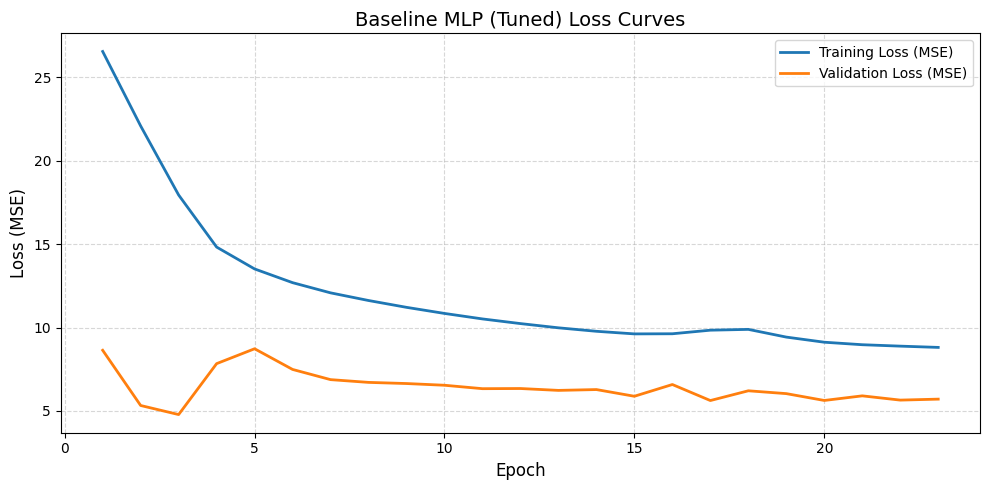

In [53]:
best_row_A = results_df_A.sort_values("mean_best_val_mse").iloc[0]

best_lr_A   = float(best_row_A["learning_rate"])
best_bs_A   = int(best_row_A["batch_size"])
best_wd_A   = float(best_row_A["weight_decay"])
best_act_A  = str(best_row_A["activation"])

print("[Model A tuning] Best hyperparameters:")
print(f"  lr         = {best_lr_A}")
print(f"  batch_size = {best_bs_A}")
print(f"  weight_decay = {best_wd_A}")
print(f"  activation   = {best_act_A}\n")

n_eval_runs_A = 5
test_mses_A = []
all_val_losses_A = []
all_train_losses_A = []

print(f"[Model A tuning] Running tuned Model A {n_eval_runs_A} times...\n")

for run in range(n_eval_runs_A):

    val_losses_A, train_losses_A, test_mse_A = run_modelA(
        learning_rate=best_lr_A,
        batch_size=best_bs_A,
        weight_decay=best_wd_A,
        activation_name=best_act_A,
        num_epochs=200,
        patience=20,
        evaluate_model=True,
        extra_info=(run == 0),  # only print per-epoch info on first run
    )

    test_mses_A.append(test_mse_A)
    all_val_losses_A.append(val_losses_A)
    all_train_losses_A.append(train_losses_A)

    print(f" Run {run+1}/{n_eval_runs_A} → Test MSE = {test_mse_A:.6f}")

mean_test_mse_A = float(np.mean(test_mses_A))
std_test_mse_A  = float(np.std(test_mses_A))

print(f"Mean Test MSE over {n_eval_runs_A} runs : {mean_test_mse_A:.6f}")
print(f"Std Dev of Test MSE                    : {std_test_mse_A:.6f}")

# Plot last run's curves
plot_loss_curves(all_train_losses_A[-1], all_val_losses_A[-1], "Baseline MLP (Tuned)")


The baseline MLP with a tuned set of hyperparameters seems to improve the model not by much bringing it from 26 to 24.

### Wider + Deeper (Model B)

#### Class definition

In [38]:
class Wider_Deeper_MLP(nn.Module):
    def __init__(self, in_features, out_features, activation_name="relu"):
        super().__init__()

        # Choose activation
        if activation_name.lower() == "relu":
            act = nn.ReLU()
        elif activation_name.lower() == "tanh":
            act = nn.Tanh()
        elif activation_name.lower() in ["leaky_relu", "leaky-relu", "lrelu"]:
            act = nn.LeakyReLU()
        else:
            raise ValueError(f"Unknown activation_name: {activation_name}")

        self.net = nn.Sequential(
            nn.Linear(in_features, 32),  # hidden layer (wider)
            act,
            nn.Linear(32, 16),           # hidden layer (deeper)
            act,
            nn.Linear(16, out_features)  # output layer
        )

        # He (Kaiming) initialisation
        for m in self.net:
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, nonlinearity="relu")
                nn.init.zeros_(m.bias)

    def forward(self, x):
        return self.net(x)

model_B = Wider_Deeper_MLP(input_dim, output_dim).to(device)
print(model_B)


Wider_Deeper_MLP(
  (net): Sequential(
    (0): Linear(in_features=9, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=1, bias=True)
  )
)


#### Loss function and optimiser

In [27]:
criterion_B = nn.MSELoss()
optimiser_B = optim.Adam(model_B.parameters(), lr=1e-3)

#### Training loop

[Model B] Epoch 001 | Train MSE: 19.701892 | Val MSE: 4.340440
[Model B] Epoch 002 | Train MSE: 18.054161 | Val MSE: 4.344973
[Model B] Epoch 003 | Train MSE: 16.842538 | Val MSE: 4.803500
[Model B] Epoch 004 | Train MSE: 15.934372 | Val MSE: 5.520187
[Model B] Epoch 005 | Train MSE: 15.277115 | Val MSE: 6.240906
[Model B] Epoch 006 | Train MSE: 14.811507 | Val MSE: 6.759705
[Model B] Epoch 007 | Train MSE: 14.444928 | Val MSE: 7.038382
[Model B] Epoch 008 | Train MSE: 14.137858 | Val MSE: 7.136337
[Model B] Epoch 009 | Train MSE: 13.861981 | Val MSE: 7.134313
[Model B] Epoch 010 | Train MSE: 13.608103 | Val MSE: 7.111236
[Model B] Epoch 011 | Train MSE: 13.376655 | Val MSE: 7.082184
[Model B] Epoch 012 | Train MSE: 13.173943 | Val MSE: 7.070796
[Model B] Epoch 013 | Train MSE: 12.979480 | Val MSE: 7.056881
[Model B] Epoch 014 | Train MSE: 12.805986 | Val MSE: 7.030616
[Model B] Epoch 015 | Train MSE: 12.646276 | Val MSE: 6.994390
[Model B] Epoch 016 | Train MSE: 12.496511 | Val MSE: 6

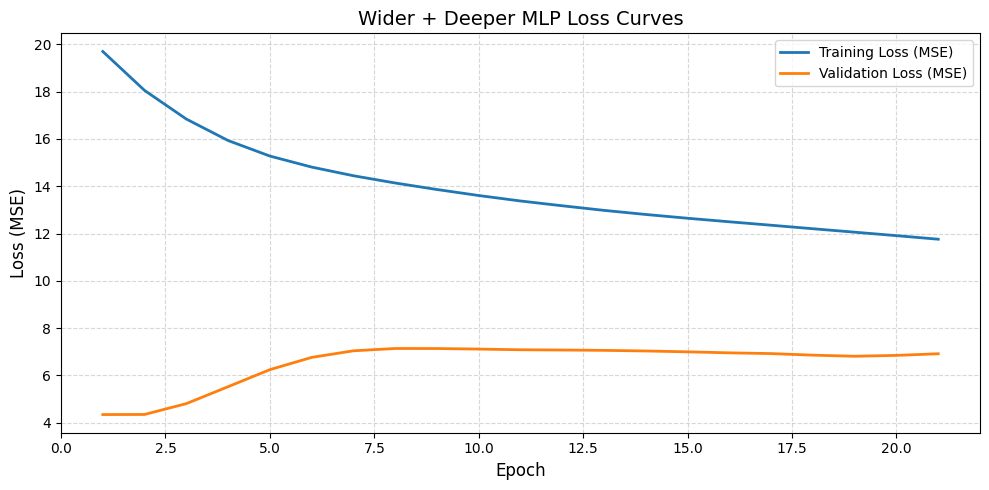

In [28]:
num_epochs_B = 200 # max number of epochs
patience_B = 20  # if validation loss doesnt improve after this many epochs, stop.

best_val_loss_B = float("inf")
best_model_state_B = None
epochs_no_improve_B = 0

train_losses_B = []
val_losses_B = []

for epoch in range(1, num_epochs_B + 1):
    train_loss = train_one_epoch(model_B, train_loader, optimiser_B, criterion_B, device)
    val_loss = evaluate(model_B, val_loader, criterion_B, device)

    train_losses_B.append(train_loss)
    val_losses_B.append(val_loss)

    print(f"[Model B] Epoch {epoch:03d} | Train MSE: {train_loss:.6f} | Val MSE: {val_loss:.6f}")

    if val_loss < best_val_loss_B - 1e-6:  # check for improvement accounting for potential noise
        best_val_loss_B = val_loss
        best_model_state_B = model_B.state_dict()
        epochs_no_improve_B = 0
    else:
        epochs_no_improve_B += 1

    if epochs_no_improve_B >= patience_B:
        print(f"[Model B] Early stopping triggered after {epoch} epochs.")
        break

# Load best model weights for Model B
if best_model_state_B is not None:
    model_B.load_state_dict(best_model_state_B)
    print("[Model B] Loaded best model (lowest val MSE).")

test_mse_B = evaluate(model_B, test_loader, criterion_B, device)
print(f"\n[Model B] Final Test MSE: {test_mse_B:.6f}")
plot_loss_curves(train_losses_B, val_losses_B, "Wider + Deeper MLP")


### Wider + Deeper MLP (Model B) Tuning

(Similar hyperparameters as Model A, uses modified code from model A tuning)

#### Model running function

In [40]:
def run_modelB(learning_rate,
               batch_size,
               weight_decay,
               activation_name,
               num_epochs=200,
               patience=20,
               extra_info=False,
               evaluate_model=False):

    # new model for each run
    model = Wider_Deeper_MLP(input_dim, output_dim, activation_name=activation_name).to(device)

    # create loaders
    train_loader, val_loader, test_loader = loaders_w_batch_size(batch_size)

    criterion  = nn.MSELoss()
    optimiser  = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    best_val_loss     = float("inf")
    best_train_loss   = float("inf")
    best_model_state  = None
    epochs_no_improve = 0

    if evaluate_model:
        train_losses = []  # only used if evaluate_model=True
        val_losses   = []  # only used if evaluate_model=True

    for epoch in range(1, num_epochs + 1):
        train_loss = train_one_epoch(model, train_loader, optimiser, criterion, device)
        val_loss   = evaluate(model, val_loader, criterion, device)

        if evaluate_model:
            train_losses.append(train_loss)
            val_losses.append(val_loss)

        if extra_info:
            print(
                f"[Model B tuning] (lr={learning_rate}, bs={batch_size}, "
                f"wd={weight_decay}, act={activation_name}) "
                f"Epoch {epoch:03d} | Train MSE: {train_loss:.6f} | Val MSE: {val_loss:.6f}"
            )

        if val_loss < best_val_loss - 1e-6:  # check for improvement accounting for potential noise
            best_val_loss   = val_loss
            best_train_loss = train_loss
            best_model_state = model.state_dict()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            break

    # Load best model weights for Model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        if extra_info:
            print("[Model B] Loaded best model (lowest val MSE).")

    if evaluate_model:
        test_mse = evaluate(model, test_loader, criterion, device)
        return val_losses, train_losses, test_mse

    return best_val_loss, best_train_loss


#### Hyperparameter Grid Search

In [45]:
learning_rate_grid_B = [1e-2, 3e-3, 1e-3]
batch_size_grid_B    = [16]
weight_decay_grid_B  = [0.0, 1e-4, 1e-3]
activation_grid_B    = ["relu", "tanh", "leaky_relu"]

hyperparameter_grid_B = list(itertools.product(
    learning_rate_grid_B,
    batch_size_grid_B,
    weight_decay_grid_B,
    activation_grid_B,
))

print(f"Total combinations to test for Model B: {len(hyperparameter_grid_B)}")

n_runs_per_setting_B = 3  # evaluate each hyperparameter combo 3 times

results_B = []

for learning_rate, batch_size, weight_decay, activation_name in hyperparameter_grid_B:
    val_mses   = []
    train_mses = []

    for run_idx in range(n_runs_per_setting_B):
        # Optional: vary seed for each repeat
        torch.manual_seed(100 + run_idx)
        np.random.seed(100 + run_idx)
        random.seed(100 + run_idx)

        best_val_mse, best_train_mse = run_modelB(
            learning_rate=learning_rate,
            batch_size=batch_size,
            weight_decay=weight_decay,
            activation_name=activation_name,
            num_epochs=200,
            patience=20,
            extra_info=False
        )

        val_mses.append(best_val_mse)
        train_mses.append(best_train_mse)

    mean_val_mse = float(np.mean(val_mses))
    std_val_mse  = float(np.std(val_mses))

    results_B.append({
        "learning_rate": learning_rate,
        "batch_size": batch_size,
        "weight_decay": weight_decay,
        "activation": activation_name,
        "mean_best_val_mse": mean_val_mse,
        "std_best_val_mse": std_val_mse,
    })

    print(
        f"[Model B tuning] Done: lr={learning_rate}, bs={batch_size}, "
        f"wd={weight_decay}, act={activation_name} "
        f"-> mean best val MSE = {mean_val_mse:.4f} (std={std_val_mse:.4f})"
    )

results_df_B = pd.DataFrame(results_B)
display(results_df_B.sort_values("mean_best_val_mse").head(10))


Total combinations to test for Model B: 27
[Model B tuning] Done: lr=0.01, bs=16, wd=0.0, act=relu -> mean best val MSE = 4.2539 (std=0.2076)
[Model B tuning] Done: lr=0.01, bs=16, wd=0.0, act=tanh -> mean best val MSE = 4.6034 (std=0.2060)
[Model B tuning] Done: lr=0.01, bs=16, wd=0.0, act=leaky_relu -> mean best val MSE = 4.3094 (std=0.2072)
[Model B tuning] Done: lr=0.01, bs=16, wd=0.0001, act=relu -> mean best val MSE = 4.2112 (std=0.0719)
[Model B tuning] Done: lr=0.01, bs=16, wd=0.0001, act=tanh -> mean best val MSE = 4.6034 (std=0.2060)
[Model B tuning] Done: lr=0.01, bs=16, wd=0.0001, act=leaky_relu -> mean best val MSE = 4.3870 (std=0.1776)
[Model B tuning] Done: lr=0.01, bs=16, wd=0.001, act=relu -> mean best val MSE = 4.2405 (std=0.1654)
[Model B tuning] Done: lr=0.01, bs=16, wd=0.001, act=tanh -> mean best val MSE = 4.6032 (std=0.2058)
[Model B tuning] Done: lr=0.01, bs=16, wd=0.001, act=leaky_relu -> mean best val MSE = 4.2892 (std=0.2508)
[Model B tuning] Done: lr=0.003, 

,learning_rate,batch_size,weight_decay,activation,mean_best_val_mse,std_best_val_mse
18,0.001,16,0.0000,relu,4.112407,0.123011
21,0.001,16,0.0001,relu,4.113270,0.122310
24,0.001,16,0.0010,relu,4.113614,0.122308
23,0.001,16,0.0001,leaky_relu,4.117993,0.130501
20,0.001,16,0.0000,leaky_relu,4.117993,0.130495
26,0.001,16,0.0010,leaky_relu,4.117998,0.130572
3,0.010,16,0.0001,relu,4.211224,0.071857
9,0.003,16,0.0000,relu,4.219684,0.116876
12,0.003,16,0.0001,relu,4.225151,0.112382
15,0.003,16,0.0010,relu,4.226389,0.111110


#### Best tune plotter

[Model B tuning] Best hyperparameters:
  lr         = 0.001
  batch_size = 16
  weight_decay = 0.0
  activation   = relu

[Model B tuning] Running tuned Model B 5 times...

[Model B tuning] (lr=0.001, bs=16, wd=0.0, act=relu) Epoch 001 | Train MSE: 27.222140 | Val MSE: 13.141092
[Model B tuning] (lr=0.001, bs=16, wd=0.0, act=relu) Epoch 002 | Train MSE: 24.742970 | Val MSE: 10.922772
[Model B tuning] (lr=0.001, bs=16, wd=0.0, act=relu) Epoch 003 | Train MSE: 22.472844 | Val MSE: 8.964845
[Model B tuning] (lr=0.001, bs=16, wd=0.0, act=relu) Epoch 004 | Train MSE: 20.379713 | Val MSE: 7.372197
[Model B tuning] (lr=0.001, bs=16, wd=0.0, act=relu) Epoch 005 | Train MSE: 18.557364 | Val MSE: 6.288484
[Model B tuning] (lr=0.001, bs=16, wd=0.0, act=relu) Epoch 006 | Train MSE: 17.043871 | Val MSE: 5.711394
[Model B tuning] (lr=0.001, bs=16, wd=0.0, act=relu) Epoch 007 | Train MSE: 15.844258 | Val MSE: 5.606049
[Model B tuning] (lr=0.001, bs=16, wd=0.0, act=relu) Epoch 008 | Train MSE: 14.9500

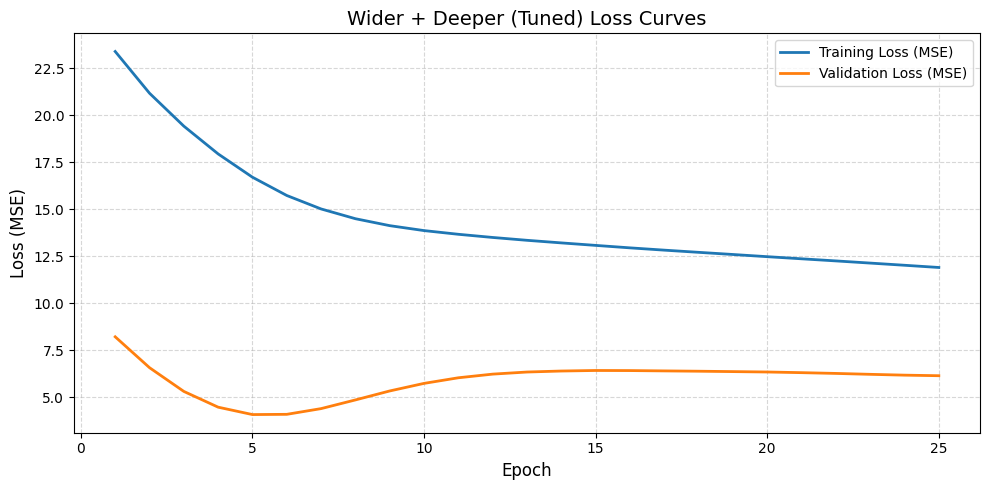

In [54]:
best_row_B = results_df_B.sort_values("mean_best_val_mse").iloc[0]

best_lr_B   = float(best_row_B["learning_rate"])
best_bs_B   = int(best_row_B["batch_size"])
best_wd_B   = float(best_row_B["weight_decay"])
best_act_B  = str(best_row_B["activation"])

print("[Model B tuning] Best hyperparameters:")
print(f"  lr         = {best_lr_B}")
print(f"  batch_size = {best_bs_B}")
print(f"  weight_decay = {best_wd_B}")
print(f"  activation   = {best_act_B}\n")

n_eval_runs_B = 5
test_mses_B = []
all_val_losses_B = []
all_train_losses_B = []

print(f"[Model B tuning] Running tuned Model B {n_eval_runs_B} times...\n")

for run in range(n_eval_runs_B):

    val_losses_B, train_losses_B, test_mse_B = run_modelB(
        learning_rate=best_lr_B,
        batch_size=best_bs_B,
        weight_decay=best_wd_B,
        activation_name=best_act_B,
        num_epochs=200,
        patience=20,
        evaluate_model=True,
        extra_info=(run == 0),  # only print per-epoch info on first run
    )

    test_mses_B.append(test_mse_B)
    all_val_losses_B.append(val_losses_B)
    all_train_losses_B.append(train_losses_B)

    print(f" Run {run+1}/{n_eval_runs_B} → Test MSE = {test_mse_B:.6f}")

mean_test_mse_B = float(np.mean(test_mses_B))
std_test_mse_B  = float(np.std(test_mses_B))

print(f"Mean Test MSE over {n_eval_runs_B} runs : {mean_test_mse_B:.6f}")
print(f"Std Dev of Test MSE                    : {std_test_mse_B:.6f}")

# Plot last run's curves
plot_loss_curves(all_train_losses_B[-1], all_val_losses_B[-1], "Wider + Deeper (Tuned)")


### Regularisation MLP (Model C)

#### Class definition

In [48]:
class regularisation_MLP(nn.Module):
    def __init__(self, in_features, out_features, dropout_p=0.2, activation_name="relu"):
        super().__init__()

        # Choose activation
        if activation_name.lower() == "relu":
            act = nn.ReLU()
        elif activation_name.lower() == "tanh":
            act = nn.Tanh()
        elif activation_name.lower() in ["leaky_relu", "leaky-relu", "lrelu"]:
            act = nn.LeakyReLU()
        else:
            raise ValueError(f"Unknown activation_name: {activation_name}")

        self.net = nn.Sequential(
            nn.Linear(in_features, 32),
            act,
            nn.Dropout(dropout_p),
            nn.Linear(32, 16),
            act,
            nn.Dropout(dropout_p),
            nn.Linear(16, out_features),
        )

        # He (Kaiming) initialisation
        for m in self.net:
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, nonlinearity="relu")
                nn.init.zeros_(m.bias)

    def forward(self, x):
        return self.net(x)

model_C = regularisation_MLP(input_dim, output_dim).to(device)
print(model_C)


regularisation_MLP(
  (net): Sequential(
    (0): Linear(in_features=9, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=16, out_features=1, bias=True)
  )
)


#### Loss function and Optimisation

In [33]:
criterion_C = nn.MSELoss()
optimiser_C = optim.Adam(model_C.parameters(), lr=1e-3)

#### Training Loop

[Model C] Epoch 001 | Train MSE: 31.699720 | Val MSE: 13.694189
[Model C] Epoch 002 | Train MSE: 27.579099 | Val MSE: 11.125891
[Model C] Epoch 003 | Train MSE: 26.271727 | Val MSE: 8.933655
[Model C] Epoch 004 | Train MSE: 25.578534 | Val MSE: 7.193082
[Model C] Epoch 005 | Train MSE: 21.289197 | Val MSE: 6.018553
[Model C] Epoch 006 | Train MSE: 20.728895 | Val MSE: 5.353343
[Model C] Epoch 007 | Train MSE: 20.076864 | Val MSE: 5.059540
[Model C] Epoch 008 | Train MSE: 17.276248 | Val MSE: 5.126499
[Model C] Epoch 009 | Train MSE: 15.565638 | Val MSE: 5.432499
[Model C] Epoch 010 | Train MSE: 16.787654 | Val MSE: 5.914533
[Model C] Epoch 011 | Train MSE: 17.160904 | Val MSE: 6.234085
[Model C] Epoch 012 | Train MSE: 15.932040 | Val MSE: 6.558404
[Model C] Epoch 013 | Train MSE: 16.129125 | Val MSE: 6.807996
[Model C] Epoch 014 | Train MSE: 15.137779 | Val MSE: 6.782032
[Model C] Epoch 015 | Train MSE: 16.970904 | Val MSE: 6.971636
[Model C] Epoch 016 | Train MSE: 15.364789 | Val MSE:

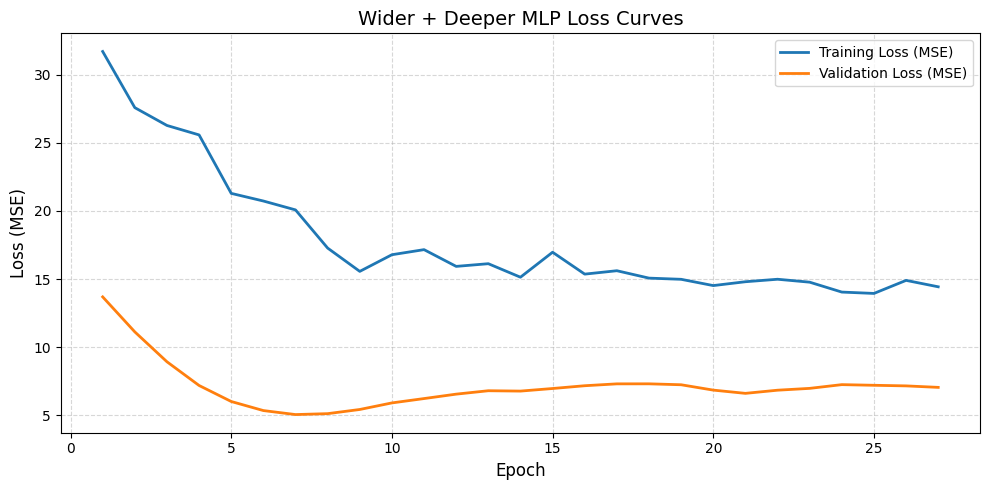

In [34]:
num_epochs_C = 200 # max number of epochs
patience_C = 20  # if validation loss doesnt improve after this many epochs, stop.

best_val_loss_C = float("inf")
best_model_state_C = None
epochs_no_improve_C = 0

train_losses_C = []
val_losses_C = []

for epoch in range(1, num_epochs_C + 1):
    train_loss = train_one_epoch(model_C, train_loader, optimiser_C, criterion_C, device)
    val_loss = evaluate(model_C, val_loader, criterion_C, device)

    train_losses_C.append(train_loss)
    val_losses_C.append(val_loss)

    print(f"[Model C] Epoch {epoch:03d} | Train MSE: {train_loss:.6f} | Val MSE: {val_loss:.6f}")

    if val_loss < best_val_loss_C - 1e-6:  # check for improvement accounting for potential noise
        best_val_loss_C = val_loss
        best_model_state_C = model_C.state_dict()
        epochs_no_improve_C = 0
    else:
        epochs_no_improve_C += 1

    if epochs_no_improve_C >= patience_C:
        print(f"[Model C] Early stopping triggered after {epoch} epochs.")
        break

# Load best model weights for Model C
if best_model_state_C is not None:
    model_C.load_state_dict(best_model_state_C)
    print("[Model C] Loaded best model (lowest val MSE).")

test_mse_C = evaluate(model_C, test_loader, criterion_C, device)
print(f"\n[Model C] Final Test MSE: {test_mse_C:.6f}")
plot_loss_curves(train_losses_C, val_losses_C, "Wider + Deeper MLP")


### Regularisation MLP Tuning

#### Model running function

In [50]:
def run_modelC(learning_rate,
               batch_size,
               weight_decay,
               dropout_p,
               activation_name,
               num_epochs=200,
               patience=20,
               extra_info=False,
               evaluate_model=False):

    # Fresh Model C for this run (same architecture as Model B, but with dropout)
    model_C = regularisation_MLP(
        input_dim,
        output_dim,
        dropout_p=dropout_p,
        activation_name=activation_name
    ).to(device)

    # Fresh loaders in case batch size changes
    train_loader, val_loader, test_loader = loaders_w_batch_size(batch_size)

    criterion  = nn.MSELoss()
    optimiser  = optim.Adam(
        model_C.parameters(),
        lr=learning_rate,
        weight_decay=weight_decay,
    )

    best_val_loss      = float("inf")
    best_train_loss    = float("inf")
    best_model_state   = None
    epochs_no_improve  = 0

    if evaluate_model:
        train_losses = []  # only used if evaluate_model=True
        val_losses   = []  # only used if evaluate_model=True

    for epoch in range(1, num_epochs + 1):
        train_loss = train_one_epoch(model_C, train_loader, optimiser, criterion, device)
        val_loss   = evaluate(model_C, val_loader, criterion, device)

        if evaluate_model:
            train_losses.append(train_loss)
            val_losses.append(val_loss)

        if extra_info:
            print(
                f"[Model C tuning] (lr={learning_rate}, bs={batch_size}, wd={weight_decay}, "
                f"p={dropout_p}, act={activation_name}) "
                f"Epoch {epoch:03d} | Train MSE: {train_loss:.6f} | Val MSE: {val_loss:.6f}"
            )

        # Early stopping based on validation loss
        if val_loss < best_val_loss - 1e-6:  # small delta to avoid floating-point noise
            best_val_loss     = val_loss
            best_train_loss   = train_loss
            best_model_state  = model_C.state_dict()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            break

    # Reload best weights
    if best_model_state is not None:
        model_C.load_state_dict(best_model_state)

    if evaluate_model:
        test_mse = evaluate(model_C, test_loader, criterion, device)
        return val_losses, train_losses, test_mse

    return best_val_loss, best_train_loss


#### Hyperparameter Grid

In [51]:
learning_rate_grid_C = [1e-3, 3e-4]
batch_size_grid_C    = [16]
weight_decay_grid_C  = [0.0, 1e-4]
dropout_grid_C       = [0.1, 0.2, 0.3]
activation_grid_C    = ["relu", "tanh", "leaky_relu"]

hyperparameter_grid_C = list(itertools.product(
    learning_rate_grid_C,
    batch_size_grid_C,
    weight_decay_grid_C,
    dropout_grid_C,
    activation_grid_C,
))

print(f"Total combinations to test for Model C: {len(hyperparameter_grid_C)}")

n_runs_per_setting_C = 3

results_C = []

for learning_rate, batch_size, weight_decay, dropout_p, activation_name in hyperparameter_grid_C:
    val_mses   = []
    train_mses = []

    for run_idx in range(n_runs_per_setting_C):
        torch.manual_seed(300 + run_idx)
        np.random.seed(300 + run_idx)
        random.seed(300 + run_idx)

        best_val_mse, best_train_mse = run_modelC(
            learning_rate=learning_rate,
            batch_size=batch_size,
            weight_decay=weight_decay,
            dropout_p=dropout_p,
            activation_name=activation_name,
            num_epochs=200,
            patience=20,
            extra_info=False
        )

        val_mses.append(best_val_mse)
        train_mses.append(best_train_mse)

    mean_val_mse = float(np.mean(val_mses))
    std_val_mse  = float(np.std(val_mses))

    results_C.append({
        "learning_rate": learning_rate,
        "batch_size": batch_size,
        "weight_decay": weight_decay,
        "dropout_p": dropout_p,
        "activation": activation_name,
        "mean_best_val_mse": mean_val_mse,
        "std_best_val_mse": std_val_mse,
    })

    print(
        f"[Model C tuning] Done: lr={learning_rate}, bs={batch_size}, "
        f"wd={weight_decay}, p={dropout_p}, act={activation_name} "
        f"-> mean best val MSE = {mean_val_mse:.4f} (std={std_val_mse:.4f})"
    )

results_df_C = pd.DataFrame(results_C)
display(results_df_C.sort_values("mean_best_val_mse").head(10))


Total combinations to test for Model C: 36
[Model C tuning] Done: lr=0.001, bs=16, wd=0.0, p=0.1, act=relu -> mean best val MSE = 4.4247 (std=0.1124)
[Model C tuning] Done: lr=0.001, bs=16, wd=0.0, p=0.1, act=tanh -> mean best val MSE = 4.6883 (std=0.0856)
[Model C tuning] Done: lr=0.001, bs=16, wd=0.0, p=0.1, act=leaky_relu -> mean best val MSE = 4.4314 (std=0.1080)
[Model C tuning] Done: lr=0.001, bs=16, wd=0.0, p=0.2, act=relu -> mean best val MSE = 4.4337 (std=0.1188)
[Model C tuning] Done: lr=0.001, bs=16, wd=0.0, p=0.2, act=tanh -> mean best val MSE = 4.7246 (std=0.0815)
[Model C tuning] Done: lr=0.001, bs=16, wd=0.0, p=0.2, act=leaky_relu -> mean best val MSE = 4.4454 (std=0.1160)
[Model C tuning] Done: lr=0.001, bs=16, wd=0.0, p=0.3, act=relu -> mean best val MSE = 4.4427 (std=0.1227)
[Model C tuning] Done: lr=0.001, bs=16, wd=0.0, p=0.3, act=tanh -> mean best val MSE = 4.7087 (std=0.0655)
[Model C tuning] Done: lr=0.001, bs=16, wd=0.0, p=0.3, act=leaky_relu -> mean best val MS

,learning_rate,batch_size,weight_decay,dropout_p,activation,mean_best_val_mse,std_best_val_mse
33,0.0003,16,0.0001,0.3,relu,4.419292,0.129875
21,0.0003,16,0.0000,0.2,relu,4.419642,0.122653
24,0.0003,16,0.0000,0.3,relu,4.419680,0.129761
30,0.0003,16,0.0001,0.2,relu,4.419915,0.122641
23,0.0003,16,0.0000,0.2,leaky_relu,4.424247,0.123951
32,0.0003,16,0.0001,0.2,leaky_relu,4.424247,0.123952
0,0.0010,16,0.0000,0.1,relu,4.424688,0.112360
9,0.0010,16,0.0001,0.1,relu,4.425202,0.111480
26,0.0003,16,0.0000,0.3,leaky_relu,4.429442,0.134162
35,0.0003,16,0.0001,0.3,leaky_relu,4.429465,0.134194


#### Best tune plotter

[Model C tuning] Best hyperparameters:
  lr         = 0.0003
  batch_size = 16
  weight_decay = 0.0001
  dropout_p    = 0.3
  activation   = relu

[Model C tuning] Running tuned Model C 5 times...

[Model C tuning] (lr=0.0003, bs=16, wd=0.0001, p=0.3, act=relu) Epoch 001 | Train MSE: 29.679180 | Val MSE: 13.648884
[Model C tuning] (lr=0.0003, bs=16, wd=0.0001, p=0.3, act=relu) Epoch 002 | Train MSE: 29.945325 | Val MSE: 12.628779
[Model C tuning] (lr=0.0003, bs=16, wd=0.0001, p=0.3, act=relu) Epoch 003 | Train MSE: 28.874045 | Val MSE: 11.645590
[Model C tuning] (lr=0.0003, bs=16, wd=0.0001, p=0.3, act=relu) Epoch 004 | Train MSE: 27.215986 | Val MSE: 10.767015
[Model C tuning] (lr=0.0003, bs=16, wd=0.0001, p=0.3, act=relu) Epoch 005 | Train MSE: 27.254762 | Val MSE: 9.991194
[Model C tuning] (lr=0.0003, bs=16, wd=0.0001, p=0.3, act=relu) Epoch 006 | Train MSE: 26.021115 | Val MSE: 9.184225
[Model C tuning] (lr=0.0003, bs=16, wd=0.0001, p=0.3, act=relu) Epoch 007 | Train MSE: 25.093559

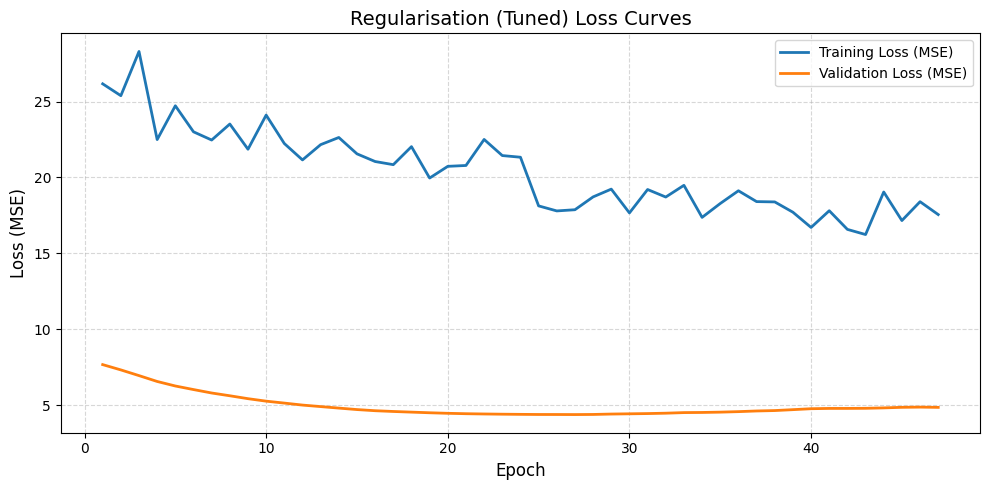

In [59]:
best_row_C = results_df_C.sort_values("mean_best_val_mse").iloc[0]

best_lr_C   = float(best_row_C["learning_rate"])
best_bs_C   = int(best_row_C["batch_size"])
best_wd_C   = float(best_row_C["weight_decay"])
best_do_C   = float(best_row_C["dropout_p"])
best_act_C  = str(best_row_C["activation"])

print("[Model C tuning] Best hyperparameters:")
print(f"  lr         = {best_lr_C}")
print(f"  batch_size = {best_bs_C}")
print(f"  weight_decay = {best_wd_C}")
print(f"  dropout_p    = {best_do_C}")
print(f"  activation   = {best_act_C}\n")

n_eval_runs_C = 5
test_mses_C = []
all_val_losses_C = []
all_train_losses_C = []

print(f"[Model C tuning] Running tuned Model C {n_eval_runs_C} times...\n")

for run in range(n_eval_runs_C):
    # torch.manual_seed(seed + run)
    # np.random.seed(seed + run)
    # random.seed(seed + run)

    val_losses_C, train_losses_C, test_mse_C = run_modelC(
        learning_rate=best_lr_C,
        batch_size=best_bs_C,
        weight_decay=best_wd_C,
        dropout_p=best_do_C,
        activation_name=best_act_C,
        num_epochs=200,
        patience=20,
        evaluate_model=True,
        extra_info=(run == 0),  # only print per-epoch info on first run
    )

    test_mses_C.append(test_mse_C)
    all_val_losses_C.append(val_losses_C)
    all_train_losses_C.append(train_losses_C)

    print(f" Run {run+1}/{n_eval_runs_C} → Test MSE = {test_mse_C:.6f}")

mean_test_mse_C = float(np.mean(test_mses_C))
std_test_mse_C  = float(np.std(test_mses_C))

print(f"Mean Test MSE over {n_eval_runs_C} runs : {mean_test_mse_C:.6f}")
print(f"Std Dev of Test MSE                    : {std_test_mse_C:.6f}")

# Plot last run's curves
plot_loss_curves(all_train_losses_C[-1], all_val_losses_C[-1], "Regularisation (Tuned)")
